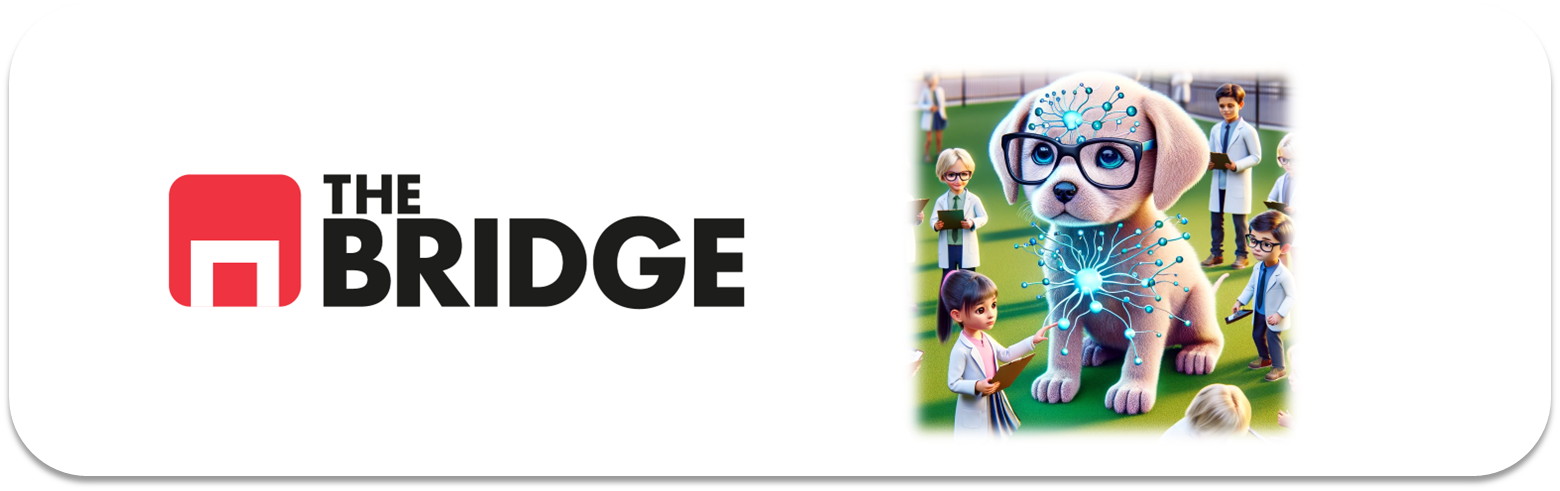

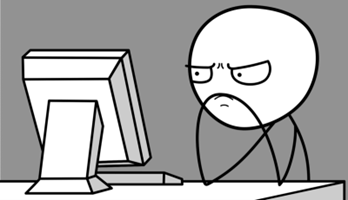

Para ejercitarte y afianzar lo aprendido sobre **Redes Recurrentes y series temporales**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [251]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

from pmdarima.arima import ARIMA, auto_arima
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from packaging import version

### Problema a resolver

El ayuntamiento de New City está preocupado por el nivel de contaminación de aire y quiere poner en marcha un sistema de prevención del uso de determinado tipo de vehículos y maquinaria pesada en aquellos días en los que la contaminación sea muy alta, en concreto queremos anticiparnos en periodos de 6 horas. Como primer paso para la implantación de la medida, decide crear un modelo de predicción de contaminación de forma que pueda emplearlo para enviar alertas o avisos de posible de prohibición con la suficiente anticipación que permita a los ciudadanos y trabajadores organizarse mejor. 

Para ello nos ha suministrado una serie de datos de contaminación del aire en cinco años dependiente de una serie de features que son medibles día a día y nos pide crear dicho modelo. Como somos unos "pioneros" vamos a hacerlo empleando lo aprendido con redes recurrentes.

A través de los siguientes ejercicios vamos a crear un modelo de regresión que permita estimar dicha polución en los periodos estimados. Aquí tienes un breve descripción de las columnas:

- **No**: número de fila
- **year**: año de los datos en esta fila
- **month**: mes de los datos en esta fila
- **day**: día de los datos en esta fila
- **hour**: hora de los datos en esta fila
- **pm2.5**: concentración de PM2.5
- **DEWP**: Punto de rocío
- **TEMP**: Temperatura
- **PRES**: Presión
- **cbwd**: Dirección combinada del viento
- **Iws**: Velocidad acumulada del viento
- **Is**: Horas acumuladas de nieve
- **Ir**: Horas acumuladas de lluvia


### Ejercicio 1: Visión preliminar

Carga el dataset. Echa un vistazo (no pintes series todavía) y decide cuál debe ser el target.

In [252]:
df= pd.read_csv(r"D:\Cursos\REPOSITORIOS\ONLINE_DS_THEBRIDGE_V\SPRINT_20_REDES_RECURRENTES\Unidad_01_Redes_Recurrentes_y_Series\ejercicios\Ejercicios_Workout\data\air_pollution_new_city.csv", sep="|")

In [253]:
df

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,25,2019,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,26,2019,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,27,2019,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,28,2019,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,29,2019,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43795,43820,2023,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43796,43821,2023,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43797,43822,2023,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43798,43823,2023,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0


In [254]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43800 entries, 0 to 43799
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      43800 non-null  int64  
 1   year    43800 non-null  int64  
 2   month   43800 non-null  int64  
 3   day     43800 non-null  int64  
 4   hour    43800 non-null  int64  
 5   pm2.5   43800 non-null  float64
 6   DEWP    43800 non-null  int64  
 7   TEMP    43800 non-null  float64
 8   PRES    43800 non-null  float64
 9   cbwd    43800 non-null  object 
 10  Iws     43800 non-null  float64
 11  Is      43800 non-null  int64  
 12  Ir      43800 non-null  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 4.3+ MB


In [255]:
#hacer un describe de todo el dataframe incluyendo los datos no numericos
df.describe(include="all").T


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
No,43800.0,NaN,NaN,NaN,21924.5,12644.115232,25.0,10974.75,21924.5,32874.25,43824.0
year,43800.0,NaN,NaN,NaN,2021.000548,1.413648,2019.0,2020.0,2021.0,2022.0,2023.0
month,43800.0,NaN,NaN,NaN,6.526575,3.447092,1.0,4.0,7.0,10.0,12.0
day,43800.0,NaN,NaN,NaN,15.73589,8.795077,1.0,8.0,16.0,23.0,31.0
hour,43800.0,NaN,NaN,NaN,11.5,6.922266,0.0,5.75,11.5,17.25,23.0
pm2.5,43800.0,NaN,NaN,NaN,94.013516,92.252276,0.0,24.0,68.0,132.25,994.0
DEWP,43800.0,NaN,NaN,NaN,1.828516,14.429326,-40.0,-10.0,2.0,15.0,28.0
TEMP,43800.0,NaN,NaN,NaN,12.459041,12.193384,-19.0,2.0,14.0,23.0,42.0
PRES,43800.0,NaN,NaN,NaN,1016.447306,10.271411,991.0,1008.0,1016.0,1025.0,1046.0
cbwd,43800,4,SE,15290,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Ejercicio 2: Preparación del dataset

Como todo dataset con series temporales, si tenemos las fechas, es conveniente convertirla a datatime y luego hacerlo el indice de nuestro dataset. Hazlo sobre un dataframe df_indexed copia del original. Deshazte de las columnas que no sean informativas y cambia el nombre de las columnas para que sean más "expresivas".

In [256]:
df_indexed=df.copy()

In [257]:
df.columns

Index(['No', 'year', 'month', 'day', 'hour', 'pm2.5', 'DEWP', 'TEMP', 'PRES',
       'cbwd', 'Iws', 'Is', 'Ir'],
      dtype='object')

In [258]:
df_indexed['date'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])

In [259]:
df_indexed

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,date
0,25,2019,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0,2019-01-02 00:00:00
1,26,2019,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0,2019-01-02 01:00:00
2,27,2019,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0,2019-01-02 02:00:00
3,28,2019,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1,0,2019-01-02 03:00:00
4,29,2019,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,2,0,2019-01-02 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43795,43820,2023,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0,2023-12-31 19:00:00
43796,43821,2023,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0,2023-12-31 20:00:00
43797,43822,2023,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0,2023-12-31 21:00:00
43798,43823,2023,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0,2023-12-31 22:00:00


In [260]:
df_indexed.drop(columns=['No', 'year', 'month', 'day', 'hour'], inplace=True)

In [261]:
df_indexed.rename(columns={'pm2.5':'Target', 'DEWP':'Rocio',"cbwd":'D_viento','Iws':'V_viento', 'Is':'Horas_nieve','Ir':'Horas_lluvia'}, inplace=True)

In [262]:
df_indexed.set_index('date', inplace=True)

In [263]:
df_indexed

,Target,Rocio,TEMP,PRES,D_viento,V_viento,Horas_nieve,Horas_lluvia
date,,,,,,,,
2019-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2019-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2019-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2019-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2019-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2023-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2023-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0


### Ejercicio 3: Split y MiniEda_I

Antes de continuar es hora analizar visualmente las series, pero para hacerlo formalmente correcto, analiza sólo de 2019 a 2022 (2023 será nuestro periodo de validaciones y test). Crea una gráfica com el target para el periodo de train. Descompón la serie de forma aditiva y analiza visualmente si existe estacionalidad, tendencia y si podríamos decir si es estacionaria o no

In [264]:
df_indexed['Target']


date
2019-01-02 00:00:00    129.0
2019-01-02 01:00:00    148.0
2019-01-02 02:00:00    159.0
2019-01-02 03:00:00    181.0
2019-01-02 04:00:00    138.0
                       ...  
2023-12-31 19:00:00      8.0
2023-12-31 20:00:00     10.0
2023-12-31 21:00:00     10.0
2023-12-31 22:00:00      8.0
2023-12-31 23:00:00     12.0
Name: Target, Length: 43800, dtype: float64

In [265]:
len(df_indexed.Target.unique())

581

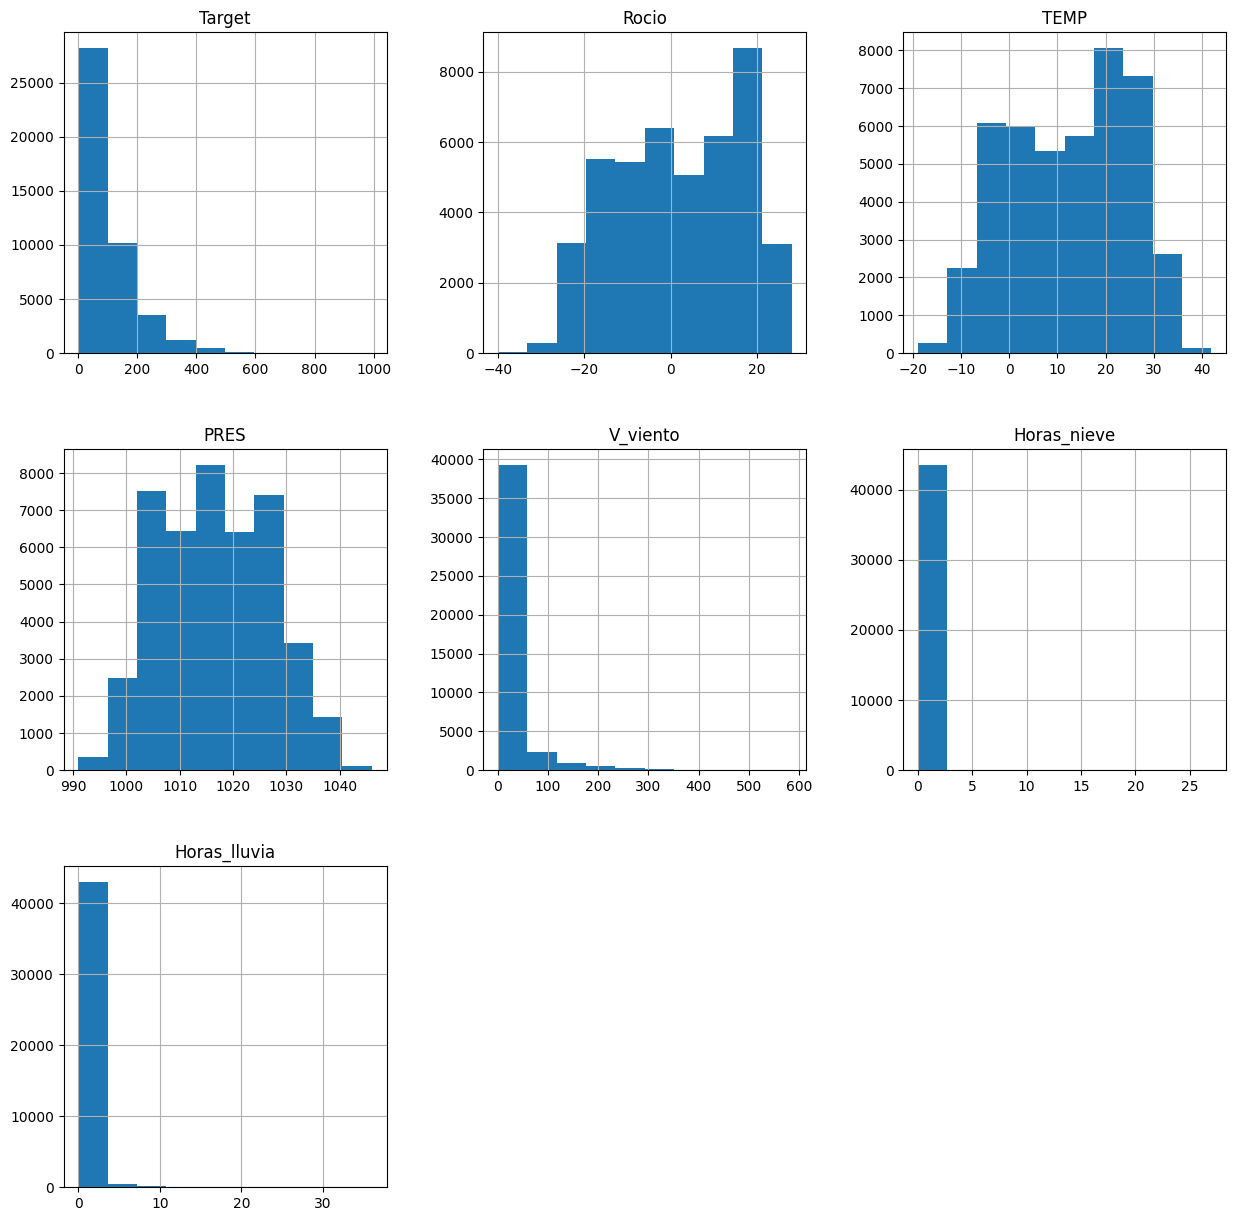

In [266]:
df_indexed.hist(figsize=(15,15));

In [267]:
col_num=['Target', 'Rocio', 'TEMP', 'PRES', 'V_viento',
       'Horas_nieve', 'Horas_lluvia']
col_cat= 'D_viento'

In [268]:
#aplicamos una constante para evitar valor infititos
df_indexed[col_num] += 1e-10

In [269]:
#logaritmizar las columnas que no siguen una distribución normal evitando la division por infinito
df_indexed['Target_log'] = np.log1p(df_indexed['Target'])
df_indexed['V_viento_log'] = np.log1p(df_indexed['V_viento'])
df_indexed['Horas_nieve_log'] = np.log1p(df_indexed['Horas_nieve'])
df_indexed['Horas_lluvia_log'] = np.log1p(df_indexed['Horas_lluvia'])
df_indexed.drop(columns=['Target', 'V_viento', 'Horas_nieve', 'Horas_lluvia'], inplace=True)

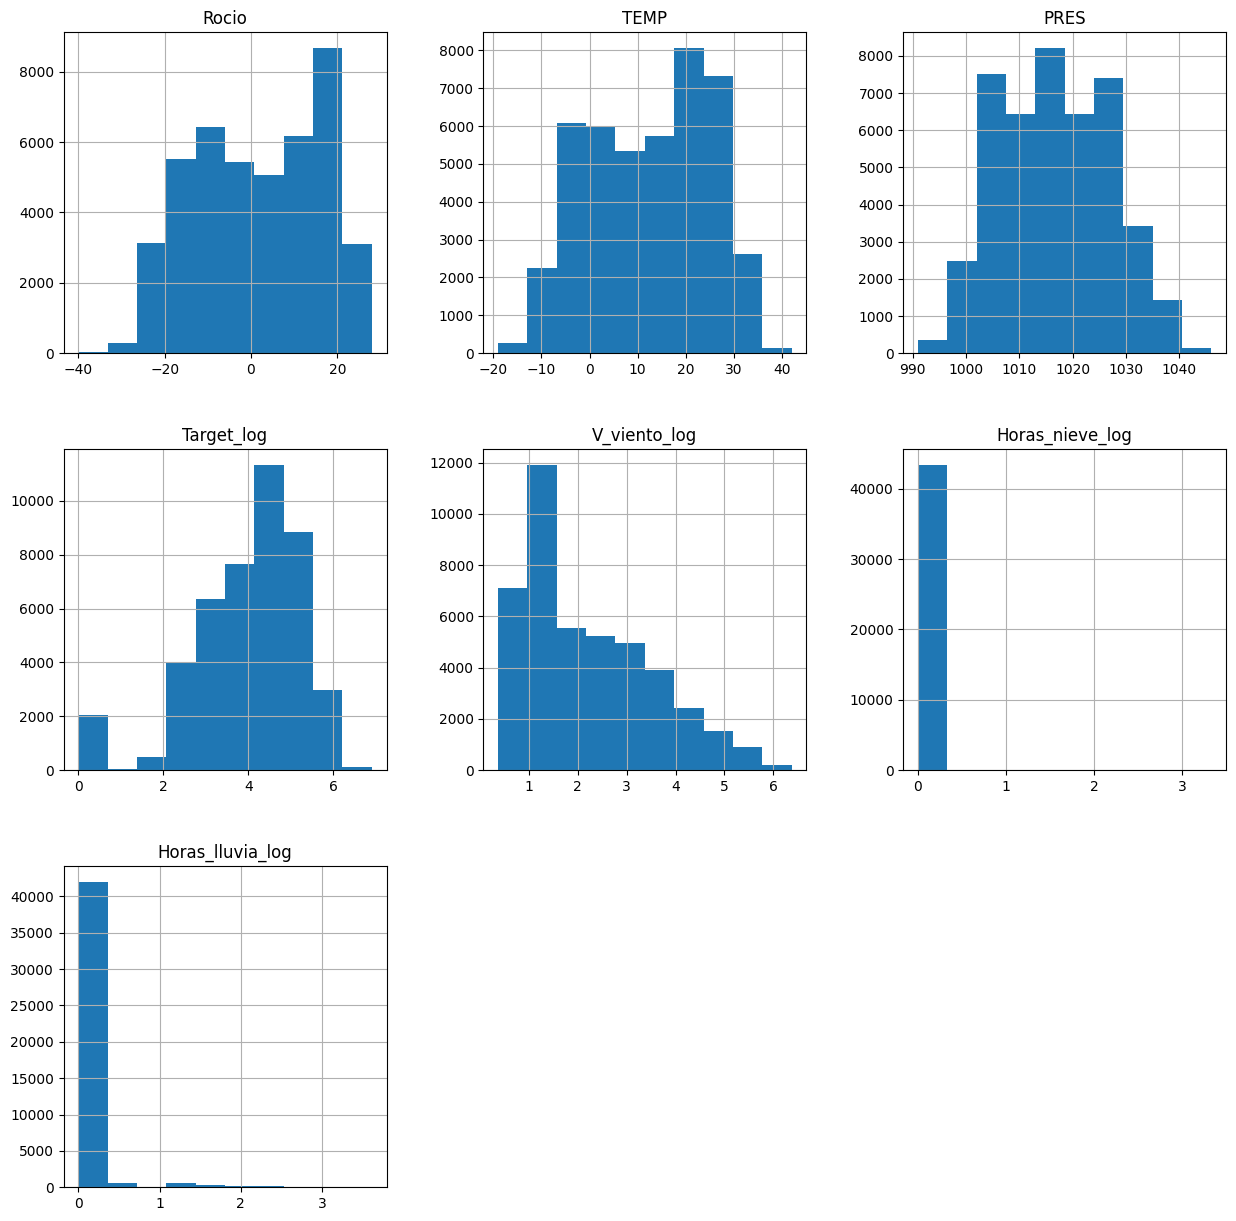

In [270]:
df_indexed.hist(figsize=(15,15));

In [271]:
df_indexed.isna().sum()

Rocio               0
TEMP                0
PRES                0
D_viento            0
Target_log          0
V_viento_log        0
Horas_nieve_log     0
Horas_lluvia_log    0
dtype: int64

In [272]:
#vamos a pasar la variable categorica a numerica
df_indexed['D_viento'].unique()

array(['SE', 'cv', 'NW', 'NE'], dtype=object)

In [273]:
df_indexed['D_viento'] = df_indexed['D_viento'].map({'cv':0, 'NW':1, 'NE':2, 'SE':3, 'SW':4})

In [274]:
#usamos diff de pandas para eliminar la estacionalidad  y la tendencia restando el valor anterior 
df_indexed['Target_log_diff'] = df_indexed['Target_log'].diff()

In [275]:
df_indexed['Target_log_diff'].isna().sum()

1

In [276]:
df_indexed.head()

,Rocio,TEMP,PRES,D_viento,Target_log,V_viento_log,Horas_nieve_log,Horas_lluvia_log,Target_log_diff
date,,,,,,,,,
2019-01-02 00:00:00,-16.0,-4.0,1020.0,3,4.867534,1.026042,1.000000e-10,1.000000e-10,NaN
2019-01-02 01:00:00,-15.0,-4.0,1020.0,3,5.003946,1.302913,1.000000e-10,1.000000e-10,0.136412
2019-01-02 02:00:00,-11.0,-5.0,1021.0,3,5.075174,1.519513,1.000000e-10,1.000000e-10,0.071228
2019-01-02 03:00:00,-7.0,-5.0,1022.0,3,5.204007,1.850028,6.931472e-01,1.000000e-10,0.128833
2019-01-02 04:00:00,-7.0,-5.0,1022.0,3,4.934474,1.981001,1.098612e+00,1.000000e-10,-0.269533


In [277]:
result = adfuller(df_indexed['Target_log_diff'].dropna())

print('ADF Statistic: %f' % result[0])# un valor alto negativo indicamas probabilidad de ser estacionaria
print('p-value: %f' % result[1])# como esta por debajo del 0.05 de significacxion estadistica , rechazamos la hipotesis nula de que no es estacionaria

ADF Statistic: -41.189499
p-value: 0.000000


In [278]:
#Como ya sabemos que nuestro dataset es estacionario ( media y varianza constantes en el tiempo), # vamos a hacer un modelo ARIMA para comparar los resultados con un modelo de ML
df_indexed.shape

(43800, 9)

In [279]:
train_size = int(df_indexed.shape[0]*0.8)# 80·% de los datos para train
test_size =  train_size - df_indexed.shape[0]# 20% de los datos para test

In [280]:
auto_arima_model = auto_arima(df_indexed['Target_log'], seasonal=True, m=6, stepwise=True, suppress_warnings=True, trace=True)# m=6 porque es la frecuencia  de la estacionalidad que queremos 6 horas 
#stepwise=True para que sea mas rapido y efciente, trace=True para ver el proceso

Performing stepwise search to minimize aic


KeyboardInterrupt: 

ValueError: Prediction must have `end` after `start`.

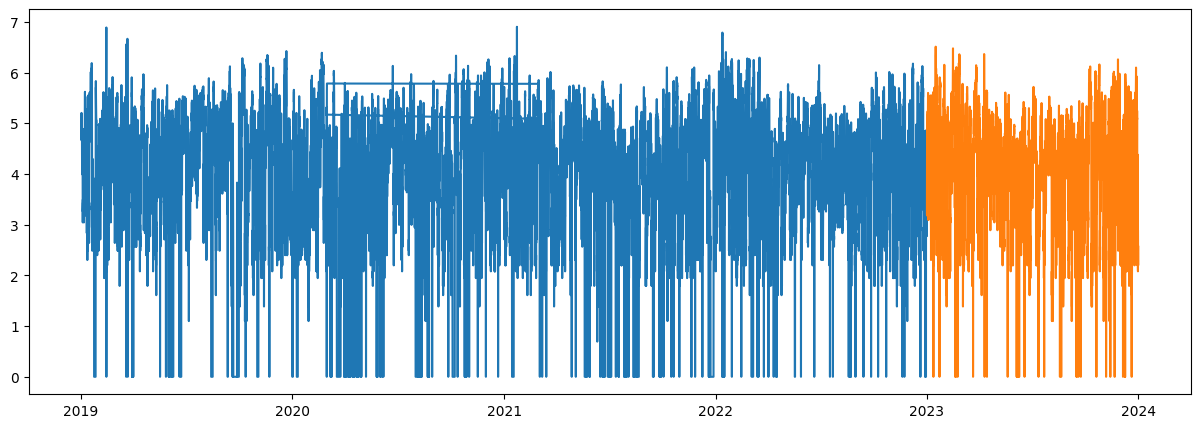

In [ ]:
#graficamos resultado de modelo arima en relacion a los datos de entrenamiento y prediciones
plt.figure(figsize=(15,5))
plt.plot(df_indexed['Target_log'][:train_size], label='Train')
plt.plot(df_indexed['Target_log'][train_size:], label='Test')
plt.plot(df_indexed.index[train_size:], auto_arima_model.predict(n_periods=test_size), label='Predictions')
plt.show()

### Ejercicio 4: MiniEDA (II)

Para completar el minieda, crea una figura con tantos subplots como series temporales y en cada subplot muestra una de las series para el train. Empieza por el target y haz un pequeño análisis visual. Por supuesto, emplea sólo el train

In [ ]:
#creamos una variable con la target y un bucle con el resto de columnas
columnas=[col for col in df_indexed.columns if col != 'Target_log']

Series_indexed= df_indexed[['Target_log']+ columnas]
Series_indexed


,Target_log,Rocio,TEMP,PRES,D_viento,V_viento_log,Horas_nieve_log,Horas_lluvia_log,Target_log_diff
date,,,,,,,,,
2019-01-02 00:00:00,4.867534,-16.0,-4.0,1020.0,3,1.026042,1.000000e-10,1.000000e-10,NaN
2019-01-02 01:00:00,5.003946,-15.0,-4.0,1020.0,3,1.302913,1.000000e-10,1.000000e-10,0.136412
2019-01-02 02:00:00,5.075174,-11.0,-5.0,1021.0,3,1.519513,1.000000e-10,1.000000e-10,0.071228
2019-01-02 03:00:00,5.204007,-7.0,-5.0,1022.0,3,1.850028,6.931472e-01,1.000000e-10,0.128833
2019-01-02 04:00:00,4.934474,-7.0,-5.0,1022.0,3,1.981001,1.098612e+00,1.000000e-10,-0.269533
...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,2.197225,-23.0,-2.0,1034.0,1,5.450910,1.000000e-10,1.000000e-10,-0.200671
2023-12-31 20:00:00,2.397895,-22.0,-3.0,1034.0,1,5.475543,1.000000e-10,1.000000e-10,0.200671
2023-12-31 21:00:00,2.397895,-22.0,-3.0,1034.0,1,5.495938,1.000000e-10,1.000000e-10,0.000000


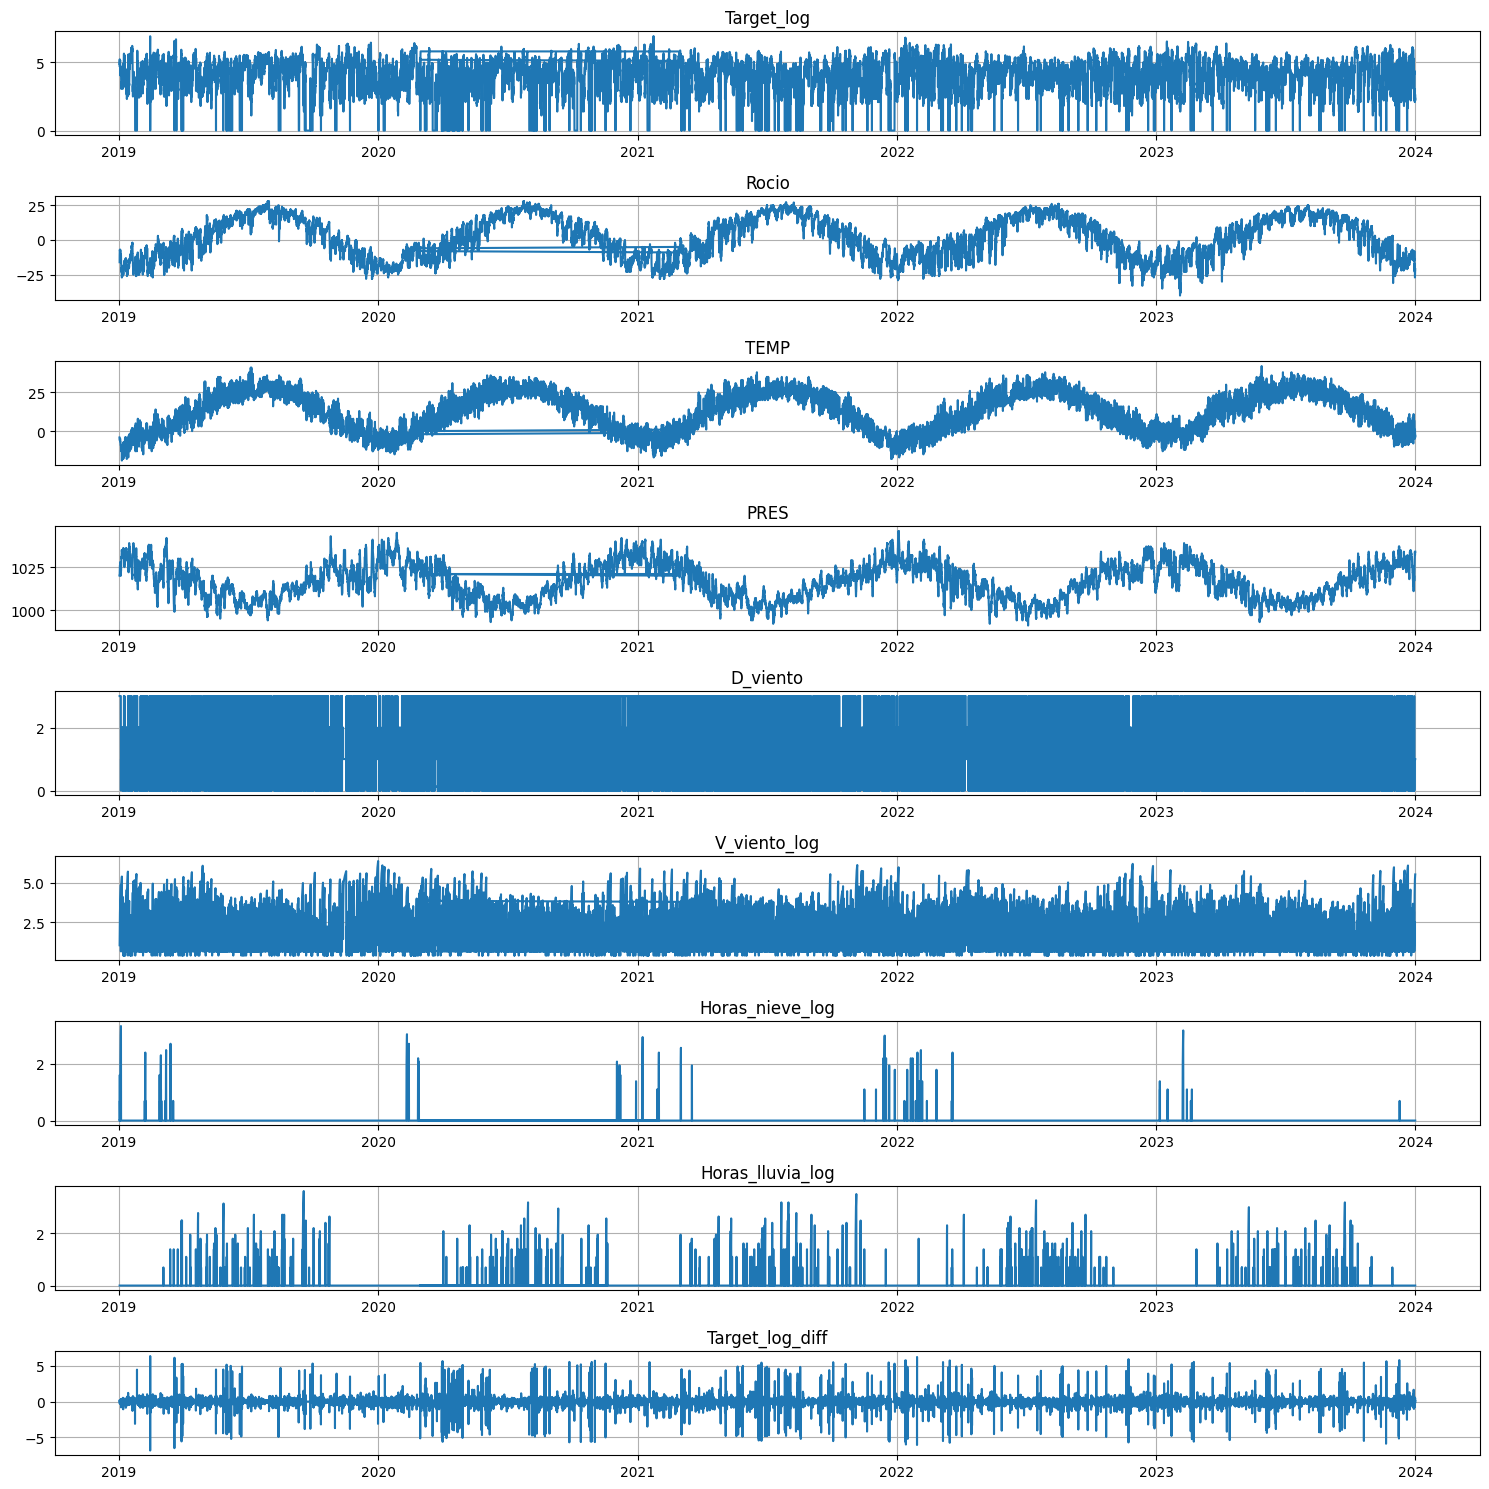

In [ ]:
#vamos a una grafica de sercies_indexed con tantos subplot como series temporales tengamos
fig, ax = plt.subplots(len(Series_indexed.columns), figsize=(15,15))
for i, col in enumerate(Series_indexed.columns):
    ax[i].plot(Series_indexed[col])
    ax[i].set_title(col)
    ax[i].grid()
plt.tight_layout()


### Ejercicio 5

Vamos a preparar el dataset. En principio vamos a predecir el valor de las siguientes 12 horas a partir de las 48 horas anteriores. Es decir hay que ajustar el dataset para que genere batches de 32 secuencias de 48 instancias y con un target que es una secuencia de los 12 periodos siguientes. Primero codifica la dirección del viento con un one-hot encoding sobre el df_indexed. Convierte todos los valores a np.float32 al final: 

In [283]:
df_indexed['D_viento'] = df_indexed['D_viento'].map({0:'cv', 1:'NW', 2:'NE', 3:'SE', 4:'SW'})

In [285]:
df_one_hot = pd.get_dummies(df_indexed['D_viento'])

In [288]:
df_indexed.drop(columns=['D_viento'], inplace=True)

In [289]:
df_indexed

,Rocio,TEMP,PRES,Target_log,V_viento_log,Horas_nieve_log,Horas_lluvia_log,Target_log_diff
date,,,,,,,,
2019-01-02 00:00:00,-16.0,-4.0,1020.0,4.867534,1.026042,1.000000e-10,1.000000e-10,NaN
2019-01-02 01:00:00,-15.0,-4.0,1020.0,5.003946,1.302913,1.000000e-10,1.000000e-10,0.136412
2019-01-02 02:00:00,-11.0,-5.0,1021.0,5.075174,1.519513,1.000000e-10,1.000000e-10,0.071228
2019-01-02 03:00:00,-7.0,-5.0,1022.0,5.204007,1.850028,6.931472e-01,1.000000e-10,0.128833
2019-01-02 04:00:00,-7.0,-5.0,1022.0,4.934474,1.981001,1.098612e+00,1.000000e-10,-0.269533
...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,-23.0,-2.0,1034.0,2.197225,5.450910,1.000000e-10,1.000000e-10,-0.200671
2023-12-31 20:00:00,-22.0,-3.0,1034.0,2.397895,5.475543,1.000000e-10,1.000000e-10,0.200671
2023-12-31 21:00:00,-22.0,-3.0,1034.0,2.397895,5.495938,1.000000e-10,1.000000e-10,0.000000


In [290]:
df_indexed_concat = pd.concat([df_indexed, df_one_hot], axis=1)

In [291]:
df_indexed_concat

,Rocio,TEMP,PRES,Target_log,V_viento_log,Horas_nieve_log,Horas_lluvia_log,Target_log_diff,NE,NW,SE,cv
date,,,,,,,,,,,,
2019-01-02 00:00:00,-16.0,-4.0,1020.0,4.867534,1.026042,1.000000e-10,1.000000e-10,NaN,0,0,1,0
2019-01-02 01:00:00,-15.0,-4.0,1020.0,5.003946,1.302913,1.000000e-10,1.000000e-10,0.136412,0,0,1,0
2019-01-02 02:00:00,-11.0,-5.0,1021.0,5.075174,1.519513,1.000000e-10,1.000000e-10,0.071228,0,0,1,0
2019-01-02 03:00:00,-7.0,-5.0,1022.0,5.204007,1.850028,6.931472e-01,1.000000e-10,0.128833,0,0,1,0
2019-01-02 04:00:00,-7.0,-5.0,1022.0,4.934474,1.981001,1.098612e+00,1.000000e-10,-0.269533,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,-23.0,-2.0,1034.0,2.197225,5.450910,1.000000e-10,1.000000e-10,-0.200671,0,1,0,0
2023-12-31 20:00:00,-22.0,-3.0,1034.0,2.397895,5.475543,1.000000e-10,1.000000e-10,0.200671,0,1,0,0
2023-12-31 21:00:00,-22.0,-3.0,1034.0,2.397895,5.495938,1.000000e-10,1.000000e-10,0.000000,0,1,0,0


In [293]:
df_indexed= df_indexed_concat.astype('float32')

In [295]:
df_indexed.to_numpy()

array([[-1.600e+01, -4.000e+00,  1.020e+03, ...,  0.000e+00,  1.000e+00,
         0.000e+00],
       [-1.500e+01, -4.000e+00,  1.020e+03, ...,  0.000e+00,  1.000e+00,
         0.000e+00],
       [-1.100e+01, -5.000e+00,  1.021e+03, ...,  0.000e+00,  1.000e+00,
         0.000e+00],
       ...,
       [-2.200e+01, -3.000e+00,  1.034e+03, ...,  1.000e+00,  0.000e+00,
         0.000e+00],
       [-2.200e+01, -4.000e+00,  1.034e+03, ...,  1.000e+00,  0.000e+00,
         0.000e+00],
       [-2.100e+01, -3.000e+00,  1.034e+03, ...,  1.000e+00,  0.000e+00,
         0.000e+00]], dtype=float32)

### Ejercicio 6

Ahora crea los datasets de train, validación y test. El primero para que tenga el periodo 2020 septiembre de 2023, el segundo para octubre de 2023 y el tercero para noviembre de 2023. Ojo ten en cuenta que vamos a necesitar tanto los valores anteriores como posteriores en los periodos (48 horas antes y 12 horas después). Escálalos (importante, escala el target por separado para poder hacer la inversión en el momento de evaluar)

In [296]:
df_train_var = df_indexed["2020":"2023-08-31"].copy()
df_valid_var = df_indexed["2023-09":"2023-10"].copy()
df_test_var = df_indexed["2023-11":"2023-12"].copy()

In [301]:
df_indexed. drop(columns=['Target_log'], inplace=True) 

In [306]:
df_indexed["Target_log_diff"].fillna(-0.000053, inplace=True)

In [312]:


df_features=df_indexed.drop("Target_log_diff", axis=1)

df_features= df_features- df_features.mean()/df_features.std()

In [315]:
df_Target= df_indexed.Target_log_diff

df_Target= df_Target-df_Target.mean()/df_Target.std()

In [332]:
df_indexed_final=pd.concat([df_Target, df_features], axis=1)

In [320]:
from sklearn.model_selection import train_test_split

In [333]:
train_temp, train_test= train_test_split(df_indexed_final, test_size=0.2, random_state=42)
train_tra, train_val= train_test_split(train_temp, test_size=0.25,  random_state=42)

In [334]:
print(train_temp.shape)
print(train_tra.shape)
print(train_val.shape)
print(train_test.shape)

(35040, 11)
(26280, 11)
(8760, 11)
(8760, 11)


In [337]:
from tensorflow import convert_to_tensor

In [338]:
train_temp_a=convert_to_tensor(train_temp)
train_tra_a=convert_to_tensor(train_tra)
train_val_a=convert_to_tensor(train_val)
train_test_a=convert_to_tensor(train_test)



### Ejercicio 8

Crea un modelo con una capa de celdas sencillas recurrentes con 32 celdas. Entrénalo. Haz la evaluación directa con el método de keras. Utilizar el rmse y el mae como métricas y obténlos en las mismas unidades que el target de partida.

In [341]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
model_8 = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 11]),
    tf.keras.layers.Dense(1)  # no activation function by default
])

In [342]:

def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500, patience = None):
    patience = int(epochs//10) if patience == None else patience # Si no nos dan "paciencia" el 10% de las épocas
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience= patience, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae","rmse"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

In [345]:

fit_and_evaluate(model_8, train_tra , train_val, learning_rate=0.05)

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

### Ejercicio 9

Crea un modelo con una capa de celdas LSTM con 32 celdas. Entrénalo. Haz la evaluación directa con el método de keras. Utilizar el rmse y el mae como métricas y obténlos en las mismas unidades que el target de partida.

### Ejercicio 10

Crea un modelo con una capa de celdas GRU con 32 celdas. Entrénalo. Haz la evaluación directa con el método de keras. Utilizar el rmse y el mae como métricas y obténlos en las mismas unidades que el target de partida.